In [1]:
!pip install tensorflow==2.0.0b1

In [9]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


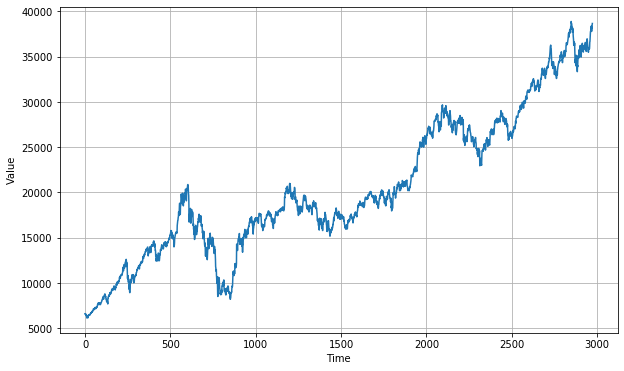

In [3]:
import csv
time_step = []
temps = []

with open(r'C:\Users\G\Desktop\chandra project\for forecasting only sensex.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
pwd

'C:\\Users\\G\\Desktop\\chandra project'

In [5]:
split_time = 2100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
#tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4000)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<DatasetV1Adapter shapes: ((?, ?, 1), (?, ?, 1)), types: (tf.float64, tf.float64)>
(2100,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 5s 565ms/step - loss: 15956.4672 - mean_absolute_error: 15952.9395
Epoch 2/100
8/8 [==============================] - 2s 277ms/step - loss: 15899.4510 - mean_absolute_error: 15897.5020
Epoch 3/100
8/8 [==============================] - 2s 288ms/step - loss: 15864.6550 - mean_absolute_error: 15860.2188
Epoch 4/100
8/8 [==============================] - 2s 276ms/step - loss: 15819.7961 - mean_absolute_error: 15814.2383
Epoch 5/100
8/8 [==============================] - 3s 378ms/step - loss: 15767.1350 - mean_absolute_error: 15761.9072
Epoch 6/100
8/8 [==============================] - 2s 262ms/step - loss: 15709.0852 - mean_absolute_error: 

8/8 [==============================] - 4s 530ms/step - loss: 4083.7101 - mean_absolute_error: 4085.2578
Epoch 65/100
8/8 [==============================] - 4s 471ms/step - loss: 3694.9722 - mean_absolute_error: 3696.3311
Epoch 66/100
8/8 [==============================] - 4s 471ms/step - loss: 3903.0904 - mean_absolute_error: 3904.2358
Epoch 67/100
8/8 [==============================] - 4s 480ms/step - loss: 3831.5088 - mean_absolute_error: 3832.9431
Epoch 68/100
8/8 [==============================] - 4s 518ms/step - loss: 4175.7987 - mean_absolute_error: 4177.6240
Epoch 69/100
8/8 [==============================] - 4s 510ms/step - loss: 4106.3223 - mean_absolute_error: 4107.1875
Epoch 70/100
8/8 [==============================] - 4s 478ms/step - loss: 3676.3189 - mean_absolute_error: 3676.9492
Epoch 71/100
8/8 [==============================] - 4s 531ms/step - loss: 4012.9365 - mean_absolute_error: 4014.5989
Epoch 72/100
8/8 [==============================] - 4s 558ms/step - loss: 371

[1e-08, 0.0001, 0, 20000]

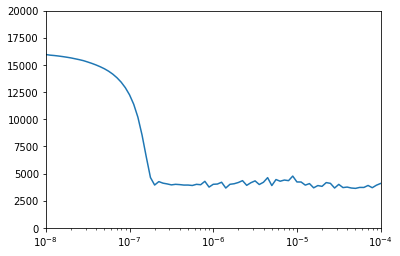

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20000])

In [12]:
tf.keras.backend.clear_session()
#tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4000)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
21/21 [==============================] - 7s 328ms/step - loss: 7518.5794 - mean_absolute_error: 7622.2876
Epoch 2/150
21/21 [==============================] - 4s 185ms/step - loss: 4183.1107 - mean_absolute_error: 4219.4526
Epoch 3/150
21/21 [==============================] - 4s 179ms/step - loss: 3773.8271 - mean_absolute_error: 3780.3262
Epoch 4/150
21/21 [==============================] - 4s 177ms/step - loss: 3646.9659 - mean_absolute_error: 3663.0564
Epoch 5/150
21/21 [==============================] - 4s 180ms/step - loss: 3986.4892 - mean_absolute_error: 3983.3616 2s - loss: 3579.2930 - mean_absolute_er
Epoch 6/150
21/21 [==============================] - 4s 181ms/step - loss: 4318.1956 - mean_absolute_error: 4318.0322
Epoch 7/150
21/21 [==============================] - 4s 187ms/step - loss: 4317.6070 - mean_absolute_error: 4338.3872
Epoch 8/150
21/21 [==============================] - 4s 212ms/step - loss: 4027.0629 - mean_absolute_error: 4050.2678
Epoch 9/150
21/2

21/21 [==============================] - 7s 352ms/step - loss: 3555.9397 - mean_absolute_error: 3563.9983
Epoch 68/150
21/21 [==============================] - 7s 339ms/step - loss: 3595.5388 - mean_absolute_error: 3593.8169
Epoch 69/150
21/21 [==============================] - 8s 375ms/step - loss: 3567.2549 - mean_absolute_error: 3580.3992
Epoch 70/150
21/21 [==============================] - 7s 350ms/step - loss: 3608.6176 - mean_absolute_error: 3601.3352
Epoch 71/150
21/21 [==============================] - 8s 374ms/step - loss: 3580.0787 - mean_absolute_error: 3589.6821
Epoch 72/150
21/21 [==============================] - 11s 501ms/step - loss: 3592.1836 - mean_absolute_error: 3590.6199
Epoch 73/150
21/21 [==============================] - 11s 529ms/step - loss: 3584.8902 - mean_absolute_error: 3602.3674
Epoch 74/150
21/21 [==============================] - 10s 488ms/step - loss: 3576.6179 - mean_absolute_error: 3562.5327
Epoch 75/150
21/21 [==============================] - 9s 4

21/21 [==============================] - 13s 637ms/step - loss: 3617.4177 - mean_absolute_error: 3590.8042
Epoch 136/150
21/21 [==============================] - 11s 535ms/step - loss: 3553.6668 - mean_absolute_error: 3569.8730
Epoch 137/150
21/21 [==============================] - 12s 578ms/step - loss: 3597.1726 - mean_absolute_error: 3580.7812
Epoch 138/150
21/21 [==============================] - 14s 647ms/step - loss: 3572.6817 - mean_absolute_error: 3574.4043
Epoch 139/150
21/21 [==============================] - 14s 650ms/step - loss: 3596.2371 - mean_absolute_error: 3584.9202
Epoch 140/150
21/21 [==============================] - 11s 538ms/step - loss: 3574.2257 - mean_absolute_error: 3575.4775
Epoch 141/150
21/21 [==============================] - 12s 561ms/step - loss: 3574.9800 - mean_absolute_error: 3561.4478
Epoch 142/150
21/21 [==============================] - 11s 540ms/step - loss: 3561.2145 - mean_absolute_error: 3567.1616
Epoch 143/150
21/21 [=========================

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

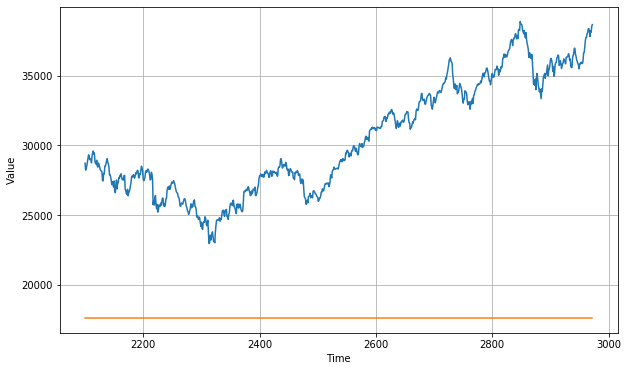

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
#tf.keras.losses.MAE(x_valid, rnn_forecast).numpy()
#tf.keras.losses.MeanAbsolutePercentageError(x_valid, rnn_forecast).numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [33]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x_valid, rnn_forecast)

12806.000201174113

In [34]:
print(rnn_forecast)

[17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36 17604.36
 17604.36 17604.36 17604.36 17604.36 17604.36 17604